In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d abdelfattahtoulaoui/celeba-facial-recognition

Dataset URL: https://www.kaggle.com/datasets/abdelfattahtoulaoui/celeba-facial-recognition
License(s): other
100% 796M/797M [00:41<00:00, 21.8MB/s]
100% 797M/797M [00:41<00:00, 20.2MB/s]


In [4]:
!unzip celeba-facial-recognition.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/197603.jpg  
  inflating: /content/images/197604.jpg  
  inflating: /content/images/197605.jpg  
  inflating: /content/images/197606.jpg  
  inflating: /content/images/197607.jpg  
  inflating: /content/images/197608.jpg  
  inflating: /content/images/197609.jpg  
  inflating: /content/images/197610.jpg  
  inflating: /content/images/197611.jpg  
  inflating: /content/images/197612.jpg  
  inflating: /content/images/197613.jpg  
  inflating: /content/images/197614.jpg  
  inflating: /content/images/197615.jpg  
  inflating: /content/images/197616.jpg  
  inflating: /content/images/197617.jpg  
  inflating: /content/images/197618.jpg  
  inflating: /content/images/197619.jpg  
  inflating: /content/images/197620.jpg  
  inflating: /content/images/197621.jpg  
  inflating: /content/images/197622.jpg  
  inflating: /content/images/197623.jpg  
  inflating: /content/images/197624.jpg  
  inflating: /content/ima

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array
import matplotlib.pyplot as plt

In [24]:
tf.random.set_seed(42)
#The csv file consists of three columns where first is anchor(person), second image is positive(same person) and third is negative(different person)
df = pd.read_csv('/content/training_triplet.csv',nrows=100000)
df.head()

,file1,file2,file3
0,007294.jpg,109830.jpg,148336.jpg
1,084495.jpg,065154.jpg,080852.jpg
2,008748.jpg,149864.jpg,065972.jpg
3,052764.jpg,151572.jpg,115456.jpg
4,198221.jpg,202437.jpg,089005.jpg


In [25]:
#Adding augmentation for rescaling between (0,1), different brightness values, zoom range and horizontal flip
generator = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7,1.5],
    zoom_range=0.2,
    horizontal_flip=True,
)
#Creating custom generator because we need to be able to pull 3 images at once
class TripletGenerator(tf.keras.utils.Sequence):
    def __init__(self,df,batch_size,image_size,**kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
    def __len__(self):
        return len(self.df)//self.batch_size
    def __getitem__(self,index):
        anchor,positive,negative = [],[],[]
        for i in range(self.batch_size):
            df_index = index*self.batch_size+i
            if df_index>= len(self.df):
                break
            anchor_path = '/content/images/'+df.loc[df_index,'file1']
            positive_path = '/content/images/'+df.loc[df_index,'file2']
            negative_path = '/content/images/'+df.loc[df_index,'file3']
            an_img = img_to_array(load_img(anchor_path,target_size=self.image_size))/255
            pos_img = img_to_array(load_img(positive_path,target_size=self.image_size))/255
            neg_img = img_to_array(load_img(negative_path,target_size=self.image_size))/255
            anchor.append(an_img)
            positive.append(pos_img)
            negative.append(neg_img)

        return (np.array(anchor), np.array(positive), np.array(negative)), np.zeros((len(anchor),))
#Instantiating triplet_generator
triplet_generator = TripletGenerator(df,batch_size=32,image_size=(128,128,3))

In [26]:
#Custom Model class to do the forward pass on all of 3 images on first then caluclate loss using triplet-loss and then backpropagate based on that loss
class Face_Recognition(tf.keras.Model):
    def __init__(self,recognition_model,margin=0.5):
        super().__init__()
        self.model = recognition_model
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
    #Defining call method to take three images at once and pass each image through the base model
    def call(self,inputs):
        print(inputs[0].shape)
        anchor = self.model(inputs[0])
        positive = self.model(inputs[1])
        negative = self.model(inputs[2])
        ap_distance = tf.reduce_sum(tf.square(anchor - positive),-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative),-1)
        return tf.stack([ap_distance, an_distance], axis=-1)
    #Defining one training step in which it should do a forward pass, remember steps of calculations using GradientTape, calculate and apply gradients
    def train_step(self,data):
        inputs, _ = data
        with tf.GradientTape() as tape:
            loss = self._compute_loss(inputs)
        gradient =  tape.gradient(loss,self.model.trainable_weights)
        self.optimizer.apply_gradients(
        zip(gradient,self.model.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {'loss':self.loss_tracker.result()}
    #Defining one test step same as training step except gradient calculation
    def test_step(self,data):
        inputs, _ = data
        loss = self._compute_loss(inputs)
        self.loss_tracker.update_state(loss)
        return {'loss':self.loss_tracker.result()}
    #Defining compute loss function which does the forward pass and calculates the loss along with margin
    def _compute_loss(self,data):
        anchor = self.model(data[0])
        positive = self.model(data[1])
        negative = self.model(data[2])
        ap_distance = tf.reduce_sum(tf.square(anchor - positive),-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative),-1)
        loss = ap_distance-an_distance
        #Selecting loss between either loss+margin or 0
        loss = tf.maximum(loss+self.margin,0)
        return loss
    #Providing a new implementation for metrics of the model to return the mean loss
    @property
    def metrics(self):
        return [self.loss_tracker]

In [27]:
input = tf.keras.layers.Input(shape=(128,128,3))
x = tf.keras.layers.Conv2D(32,(3,3),strides=1,padding='same')(input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(64,(3,3),strides=1,padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.DepthwiseConv2D((3,3),strides=1,padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.Dense(128,activation='linear')(x)
output = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t,axis=1))(x)
face_model = tf.keras.Model(inputs=input,outputs=output)

In [28]:
face_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,248,128 (16.21 MB)

 Trainable params: 4,247,808 (16.20 MB)

 Non-trainable params: 320 (1.25 KB)

In [29]:
face_recog = Face_Recognition(face_model)
face_recog.compile(optimizer=tf.keras.optimizers.Adam(0.001))

In [30]:
face_recog.fit(x=triplet_generator,epochs=20)

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 189s 59ms/step - loss: 0.2446
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 196s 58ms/step - loss: 0.1244
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 188s 60ms/step - loss: 0.0943
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 193s 62ms/step - loss: 0.0724
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 200s 61ms/step - loss: 0.0583
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 191s 61ms/step - loss: 0.0456
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 179s 57ms/step - loss: 0.0350
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 185s 59ms/step - loss: 0.0258
Epoch 9/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 191s 61ms/step - loss: 0.0201
Epoch 10/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 180s 58ms/step - loss: 0.0164
Epoch 11/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 179s 57ms/step - loss: 0.0134
Epoch 12/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 180s 57ms/step - loss: 0.0108
Epoch 13/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 190s 61ms/step - loss: 0.0090
Epoch 14/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 183s 59ms/step - 

In [32]:
face_model.save('face_recognition.h5')

In [33]:
face_model.save('face_recognition.keras')

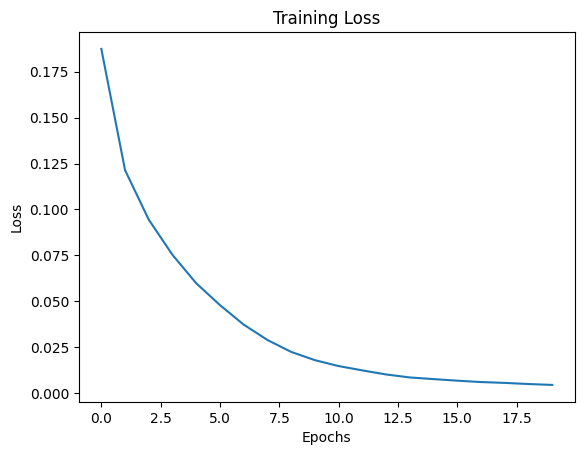

In [35]:
#Showing loss over time
plt.plot(face_recog.history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [41]:
import os
def load_image(image_name):
  img = np.expand_dims(img_to_array(load_img(os.path.join('/content/images',image_name),target_size=(128,128)))/255,axis=0)
  return img

In [53]:
df_test = df[:1000]
y_true = []
y_pred = []
distances = []
threshold = 0.7
sample_indices = np.random.choice(len(df_test), 5, replace=False)

<ipython-input-54-a9a526548fc2>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anchor_image = load_image(row[0])
<ipython-input-54-a9a526548fc2>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positive_image = load_image(row[1])
<ipython-input-54-a9a526548fc2>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_image = load_image(row[2])
<ipython-input-54-a9a526548fc2>:23: FutureWarning: Series.__getitem__ treating keys as 

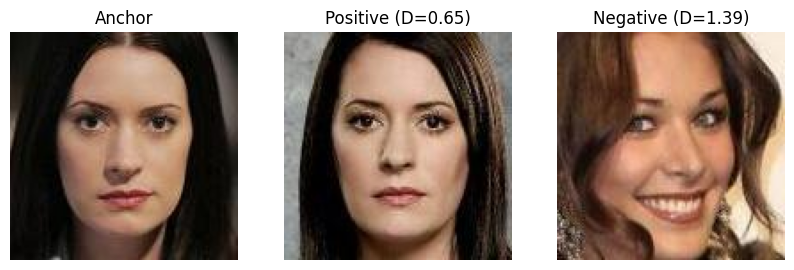

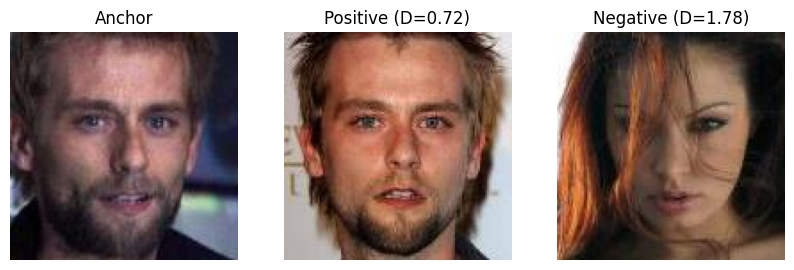

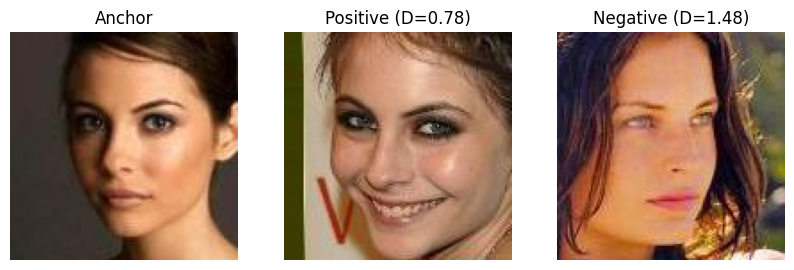

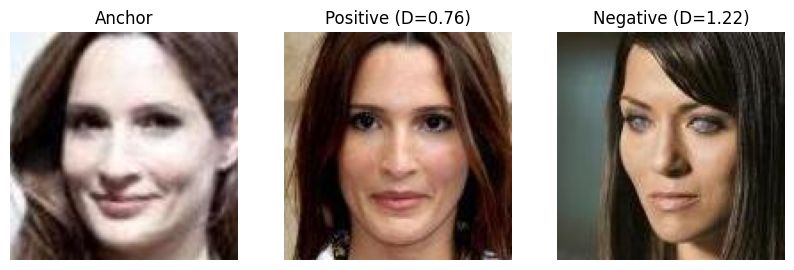

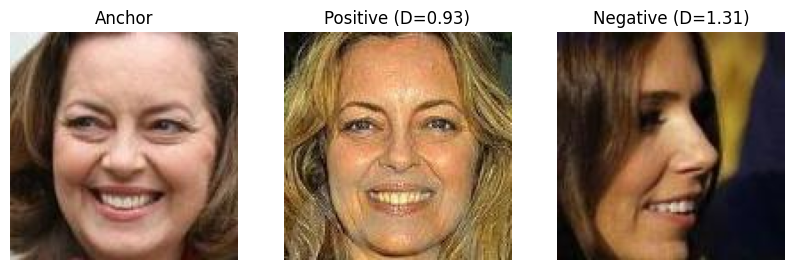

In [54]:
for idx, row in df_test.iterrows():
  anchor_image = load_image(row[0])
  positive_image = load_image(row[1])
  negative_image = load_image(row[2])

  anchor_embed = face_model(anchor_image)
  positive_embed = face_model(positive_image)
  negative_embed = face_model(negative_image)

  pos_distance = np.linalg.norm(anchor_embed - positive_embed)
  neg_distance = np.linalg.norm(anchor_embed - negative_embed)

  y_pred.append(1 if pos_distance < threshold else 0)
  y_true.append(1)

  y_pred.append(1 if neg_distance < threshold else 0)
  y_true.append(0)

  distances.append((pos_distance, neg_distance))

  if idx in sample_indices:
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))
        ax[0].imshow(load_img(os.path.join('/content/images',row[0])))
        ax[0].set_title("Anchor")
        ax[1].imshow(load_img(os.path.join('/content/images',row[1])))
        ax[1].set_title(f"Positive (D={pos_distance:.2f})")
        ax[2].imshow(load_img(os.path.join('/content/images',row[2])))
        ax[2].set_title(f"Negative (D={neg_distance:.2f})")
        for a in ax:
            a.axis("off")
        plt.show()


In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall: 0.2780
F1 Score: 0.4351


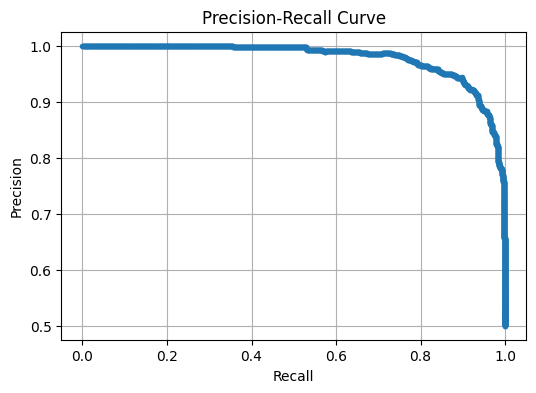

In [56]:
# Convert to numpy arrays for plotting
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Flatten the distances list
distances = np.array(distances).flatten()  # Now it has shape (2000,)

# Compute Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, 1 - distances)  # Use 1 - distances as similarity

plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()

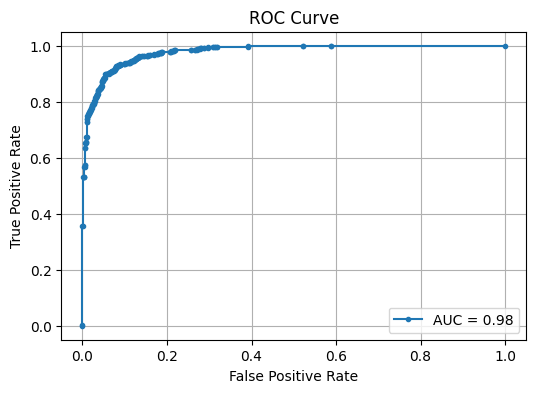

In [57]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, 1 - distances)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, marker=".", label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()